<a href="https://colab.research.google.com/github/dtuleva/DL_23_Lectures_and_Quests/blob/main/quest_01_NN_with_Tensorflow_core.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(42)

In [ ]:
# link github and colab

# Side Quest - NN with low level Tensorflow API
## part 3
### 01.Introduction-to-Deep-Learning-Basic-Models

## Multilayer Preceptron

Based on [MLP](https://www.tensorflow.org/guide/core/mlp_core); removed `tf.Model`, use pandas / numpy input instead of `tf.dataset`

In [ ]:
class Normalize:
  def __init__(self, x):
    # Initialize the mean and standard deviation for normalization
    self.mean = tf.math.reduce_mean(x, axis=0)
    self.std = tf.math.reduce_std(x, axis=0)

  def norm(self, x):
    # Normalize the input
    return (x - self.mean)/self.std

  def unnorm(self, x):
    # Unnormalize the input
    return (x * self.std) + self.mean

In [ ]:
def xavier_init(shape): # same as tf.keras.initializers.GlorotUniform
  # Computes the xavier initialization values for a weight matrix
  in_dim, out_dim = shape
  xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))
  weight_vals = tf.random.uniform(shape=(in_dim, out_dim),
                                  minval=-xavier_lim, maxval=xavier_lim, seed=42)
  return weight_vals

In [ ]:
class DenseLayer:

  def __init__(self, out_dim, weight_init=xavier_init, activation=tf.identity):
    # Initialize the dimensions and activation functions
    self.out_dim = out_dim
    self.weight_init = weight_init
    self.activation = activation
    self.built = False

  def __call__(self, x):
    if not self.built:
      # Infer the input dimension based on first call
      self.in_dim = x.shape[1]
      # Initialize the weights and biases
      self.w = tf.Variable(self.weight_init(shape=(self.in_dim, self.out_dim)))
      self.b = tf.Variable(tf.zeros(shape=(self.out_dim,)))
      self.built = True
    # Compute the forward pass
    z = tf.add(tf.matmul(x, self.w), self.b)
    return self.activation(z)

  @property
  def variables(self):  # instead of tf.Module
    # Weights and biases
    return self.w, self.b

In [ ]:
class MLP:
  #  class for Multilayer Perceptron - model that executes layers sequentially
  def __init__(self, layers):
    self.layers = layers
    self.built = False

  @tf.function
  def __call__(self, x):
    # Execute the model's layers sequentially
    for layer in self.layers:
      x = layer(x)
    return x

  @property
  def variables(self):
    # Flattened list of the weights and biases of all layers
    return [variable for layer in self.layers for variable in layer.variables]


  @property
  def history(self):
    model_history = {
        "train_loss": self.train_losses,
        "train_metric": self.train_metrics,
        "val_loss": self.val_losses,
        "val_metric": self.val_metrics
    }
    return model_history

  def compile(self, loss, metric, optimizer = tf.identity):
      self.loss = loss
      self.metric = metric
      self.optimizer = optimizer

      # Initialize loss and metric history
      self.train_losses = []
      self.train_metrics = []
      self.val_losses = []
      self.val_metrics = []

      # Update build status
      self.built = True


  def train_step(self, x_batch, y_batch):
    # Update the model state given a batch of data
    with tf.GradientTape() as tape:
      y_pred = self(x_batch)
      batch_loss = self.loss(y_pred, y_batch)
    batch_metric = self.metric(y_pred, y_batch)
    grads = tape.gradient(batch_loss, self.variables)
    self.optimizer.apply_gradients(grads, self.variables)
    return batch_loss, batch_metric


  def val_step(self, x_batch, y_batch):
    # Evaluate the model on given a batch of validation data
    y_pred = self(x_batch)
    batch_loss = self.loss(y_pred, y_batch)
    batch_metric = self.metric(y_pred, y_batch)
    return batch_loss, batch_metric


  @staticmethod
  def batch_generator(data, batch_size = -1):
    # Generates (attributes, target) tuple
    # batch_size is number of samples in batch
    # last batch can contain fewer samples

    if batch_size == -1: # batch = whole dataset = epoch
      yield data
      return

    start_idx = 0
    end_idx = batch_size
    len_data = data[0].shape[0]

    while end_idx < len_data:
      x_batch = data[0][start_idx : end_idx]
      y_batch = data[1][start_idx : end_idx]

      yield x_batch, y_batch

      start_idx += batch_size
      end_idx += batch_size


  def fit(self, train_data, val_data, epochs = 1, batch_train_size = -1, batch_val_size = -1):
    if not self.built:
      raise Exception("You must compile your model before training/testing. Use `compile(loss, metric)`.")

    # Format training loop and begin training
    for epoch in range(epochs):
      batch_losses_train, batch_metrics_train = [], []
      batch_losses_val, batch_metrics_val = [], []

      # Iterate over the training data
      for x_batch, y_batch in self.batch_generator(train_data, batch_train_size):

        # Compute gradients and update the model's parameters
        batch_loss, batch_metric = self.train_step(x_batch, y_batch)
        # Keep track of batch-level training performance
        batch_losses_train.append(batch_loss)
        batch_metrics_train.append(batch_metric)

      # Iterate over the validation data
      for x_batch, y_batch in self.batch_generator(val_data, batch_val_size):
        batch_loss, batch_metric = self.val_step(x_batch, y_batch)
        batch_losses_val.append(batch_loss)
        batch_metrics_val.append(batch_metric)

      # Keep track of epoch-level model performance
      train_loss, train_metric = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_metrics_train)
      val_loss, val_metric = tf.reduce_mean(batch_losses_val), tf.reduce_mean(batch_metrics_val)
      self.train_losses.append(train_loss)
      self.train_metrics.append(train_metric)
      self.val_losses.append(val_loss)
      self.val_metrics.append(val_metric)
      print(f"Epoch: {epoch}")
      print(f"Training loss: {train_loss:.3f}, Training metric: {train_metric:.3f}")
      print(f"Validation loss: {val_loss:.3f}, Validation metric: {val_metric:.3f}")

    return self.history




In [ ]:
@tf.function
def mse_loss_tf(y_pred, y): # _tf for all functions and classes defined in this notebook, to differentiate them from built-in tf functions
  return tf.reduce_mean(tf.square(y_pred - y))

In [ ]:
@tf.function
def relu_activation_tf(x):
  return tf.maximum(x, 0)

In [ ]:
tf.sigmoid # activation

<function tensorflow.python.ops.math_ops.sigmoid(x, name=None)>

In [ ]:
class SGD_tf:
  def __init__(self, learning_rate):
    self.learning_rate = learning_rate

  def apply_gradients(self, grads, model_variables):
    for g,v in zip(grads, model_variables):
      v.assign_sub(self.learning_rate * g)

### Regression

In [ ]:
housing_data_train = pd.read_csv("sample_data/california_housing_train.csv")
housing_data_test = pd.read_csv("sample_data/california_housing_test.csv")

In [ ]:
target_idx = housing_data_train.columns.get_loc("median_house_value")

In [ ]:
housing_data_train_tf = tf.convert_to_tensor(housing_data_train, dtype=tf.float32)
housing_data_test_tf = tf.convert_to_tensor(housing_data_test, dtype=tf.float32)

housing_data_train_tf.shape, housing_data_test_tf.shape

(TensorShape([17000, 9]), TensorShape([3000, 9]))

In [ ]:
dataset_shuffled = tf.random.shuffle(housing_data_train_tf, seed = 42)

validation_set_size = 5000

train_data, val_data = dataset_shuffled[validation_set_size:], dataset_shuffled[:validation_set_size]
attributes_train, target_train = train_data[:, 0:target_idx], train_data[:, target_idx]
attributes_val, target_val = val_data[:, 0:target_idx], val_data[:, target_idx]

attributes_test, target_test = housing_data_test_tf[:, 0:target_idx], housing_data_test_tf[:, target_idx]

(
    attributes_train.shape, target_train.shape,
    attributes_val.shape, target_val.shape,
    attributes_test.shape, target_test.shape
  )

(TensorShape([12000, 8]),
 TensorShape([12000]),
 TensorShape([5000, 8]),
 TensorShape([5000]),
 TensorShape([3000, 8]),
 TensorShape([3000]))

In [ ]:
scaler = Normalize(attributes_train)
# scaler.mean, scaler.std

In [ ]:
attributes_train = scaler.norm(attributes_train)
attributes_val = scaler.norm(attributes_val)
attributes_test = scaler.norm(attributes_test)

In [ ]:
# scaler.mean, scaler.std

In [ ]:
scaler_target = Normalize(target_train)

In [ ]:
target_train = scaler_target.norm(target_train)
target_val = scaler_target.norm(target_val)
target_test = scaler_target.norm(target_test)

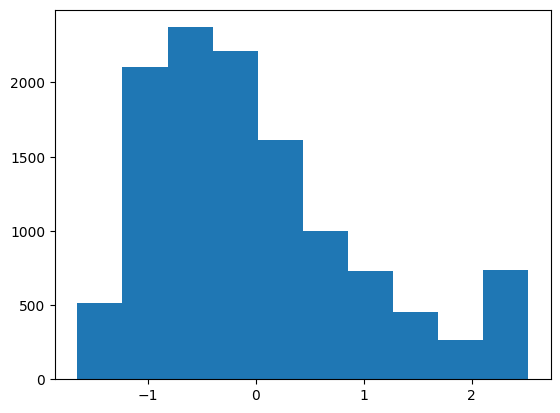

In [ ]:
plt.hist(target_train.numpy())
plt.show()

In [ ]:
num_columns = attributes_train.shape[1]
num_outputs = 1 # Regression

num_columns

8

In [ ]:
regression_model = MLP([
    DenseLayer(4, activation = tf.sigmoid),
    DenseLayer(3, activation = relu_activation_tf),
    DenseLayer(2, activation = relu_activation_tf),
    DenseLayer(num_outputs)
])

In [ ]:
sgd = SGD_tf(learning_rate = 0.01)

In [ ]:
regression_model.compile(mse_loss_tf, mse_loss_tf, optimizer = sgd)

In [ ]:
train_data = attributes_train, target_train
val_data = attributes_val, target_val

In [ ]:
regression_model.fit(
    # First call or fit initialises the model
    train_data,
    val_data,
    epochs = 1,
    batch_train_size = -1,
    batch_val_size = -1
)

Epoch: 0
Training loss: 1.257, Training metric: 1.257
Validation loss: 1.224, Validation metric: 1.224


{'train_loss': [<tf.Tensor: shape=(), dtype=float32, numpy=1.2571446>],
 'train_metric': [<tf.Tensor: shape=(), dtype=float32, numpy=1.2571446>],
 'val_loss': [<tf.Tensor: shape=(), dtype=float32, numpy=1.2241609>],
 'val_metric': [<tf.Tensor: shape=(), dtype=float32, numpy=1.2241609>]}

In [ ]:
params_init = [tf.identity(variable) for variable in regression_model.variables]
predictions_init = regression_model(attributes_test)
# params_init

In [ ]:
history = regression_model.fit(
    train_data,
    val_data,
    epochs = 20,
    batch_train_size = 5000,
    batch_val_size = -1
)

Epoch: 0
Training loss: 1.207, Training metric: 1.207
Validation loss: 1.170, Validation metric: 1.170
Epoch: 1
Training loss: 1.157, Training metric: 1.157
Validation loss: 1.131, Validation metric: 1.131
Epoch: 2
Training loss: 1.121, Training metric: 1.121
Validation loss: 1.103, Validation metric: 1.103
Epoch: 3
Training loss: 1.096, Training metric: 1.096
Validation loss: 1.083, Validation metric: 1.083
Epoch: 4
Training loss: 1.076, Training metric: 1.076
Validation loss: 1.067, Validation metric: 1.067
Epoch: 5
Training loss: 1.062, Training metric: 1.062
Validation loss: 1.055, Validation metric: 1.055
Epoch: 6
Training loss: 1.051, Training metric: 1.051
Validation loss: 1.046, Validation metric: 1.046
Epoch: 7
Training loss: 1.043, Training metric: 1.043
Validation loss: 1.039, Validation metric: 1.039
Epoch: 8
Training loss: 1.036, Training metric: 1.036
Validation loss: 1.034, Validation metric: 1.034
Epoch: 9
Training loss: 1.031, Training metric: 1.031
Validation loss: 1.

In [ ]:
# history

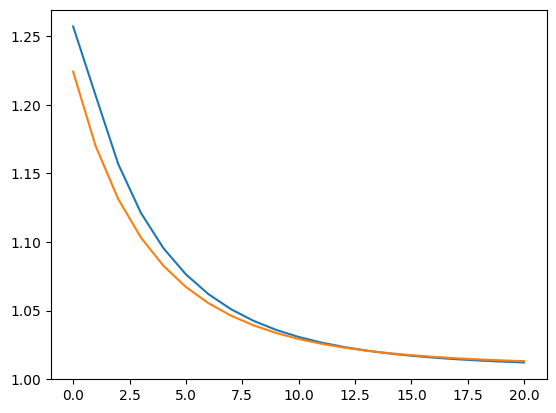

In [ ]:
plt.plot(history["train_loss"])
plt.plot(history["val_loss"])

# plt.semilogy()
plt.show()

In [ ]:
predictions_test = regression_model(attributes_test)

mse_loss_tf(predictions_test, target_test)


<tf.Tensor: shape=(), dtype=float32, numpy=0.96413213>

In [ ]:
params_trained = regression_model.variables
# params_trained

In [ ]:
# Compare weights and biases before and after training
# True means equal, false means different
for variable_init, variable_trained in zip(params_init, params_trained):
  print(tf.math.reduce_all(tf.equal(variable_init, variable_trained)).numpy())

False
False
False
False
False
False
False
False


In [ ]:
for variable_init, variable_trained in zip(params_init, params_trained):
  print((variable_init, variable_trained))

(<tf.Tensor: shape=(8, 4), dtype=float32, numpy=
array([[-0.11837932, -0.32706773, -0.0286511 , -0.19144665],
       [ 0.6430731 ,  0.6247042 ,  0.16230913, -0.20030929],
       [ 0.13237119, -0.40231365, -0.597568  ,  0.11203878],
       [-0.29443976, -0.32911637, -0.18362671,  0.3056631 ],
       [-0.05830197, -0.54061997, -0.40903762,  0.06254921],
       [ 0.6926866 , -0.16400144, -0.64082474,  0.5259184 ],
       [-0.34108877,  0.52779794,  0.20790955, -0.11335713],
       [-0.3656106 , -0.57189345,  0.68183404, -0.4849986 ]],
      dtype=float32)>, <tf.Variable 'Variable:0' shape=(8, 4) dtype=float32, numpy=
array([[-0.11921067, -0.32092872, -0.02702861, -0.18990439],
       [ 0.6439586 ,  0.6185679 ,  0.1605063 , -0.20201905],
       [ 0.13208956, -0.40109128, -0.5972651 ,  0.11244056],
       [-0.2947266 , -0.32673606, -0.18300593,  0.3063037 ],
       [-0.05856249, -0.5385452 , -0.40847924,  0.06314047],
       [ 0.69238853, -0.16179194, -0.64019054,  0.52657557],
       [-0.3

In [ ]:
tf.math.reduce_all(tf.equal(predictions_init, predictions_test)).numpy()

False